## SVM Text Data - Python

## Set up data

In [68]:
# Load essential libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import seaborn as sns 
import matplotlib.pyplot as plt

# Read csv files as df
df1 = pd.read_csv('../data/cleaned_goldman_sachs_tweets.csv', on_bad_lines='skip')
df2 = pd.read_csv('../data/cleaned_apple_tweets.csv', on_bad_lines='skip')
df3 = pd.read_csv('../data/cleaned_home_depot_tweets.csv', on_bad_lines='skip')

# Print the head of each df
print(df1.head())
print(df2.head())
print(df3.head())


    goldman
0     sachs
1   laporta
2  tomorrow
3   goldman
4     sachs
       email
0       want
1  something
2       must
3   approach
4     slowly
       koch
0  industry
1  american
2   crystal
3     sugar
4      home


## Class distribution

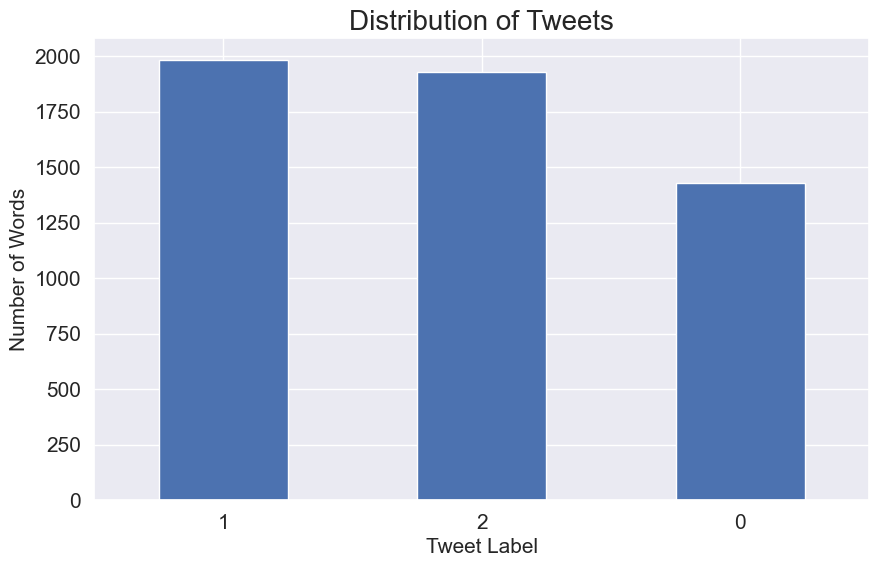

In [69]:
## Examine class distribution
sns.set(font_scale=1.2)

# Visualize class distribution
df['company'] = pd.factorize(df.company, sort=True)[0]

fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))

df['company'].value_counts().plot(kind='bar',
                            rot=0,
                            fontsize=15,
                            ax=ax1)
ax1.set_title('Distribution of Tweets', fontsize=20)
ax1.set_xlabel('Tweet Label', fontsize=15)
ax1.set_ylabel('Number of Words', fontsize=15)

# save picture
fig1 = ax1.get_figure()
fig1.savefig("../501-project-website/images/SVM_tweet_labels_distribution.png")

## Baseline Model

In [70]:
## Baseline model
import random
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

def generate_label_data(class_labels, weights,N=10000):
    y=random.choices(class_labels, weights = weights, k = N)
    print("-----GENERATING DATA-----")
    print("unique entries:",Counter(y).keys())  
    print("count of labels:",Counter(y).values()) # counts the elements' frequency
    print("probability of labels:",np.fromiter(Counter(y).values(), dtype=float)/len(y)) # counts the elements' frequency
    return y

## Generate random classifier
def random_classifier(y_data):
    ypred=[];
    max_label=np.max(y_data); #print(max_label)
    for i in range(0,len(y_data)):
        ypred.append(int(np.floor((max_label+1)*np.random.uniform(0,1))))

    print("-----RANDOM CLASSIFIER-----")
    print("count of prediction:",Counter(ypred).values()) # counts the elements' frequency
    print("probability of prediction:",np.fromiter(Counter(ypred).values(), dtype=float)/len(y_data)) # counts the elements' frequency
    print("accuracy",accuracy_score(y_data, ypred))
    print("percision, recall, fscore,",precision_recall_fscore_support(y_data, ypred))

# Random classifier
print("\MULTI-CLASS: UNIFORM LOAD")
y=generate_label_data([0,1,2],[1/3, 1/3, 1/3],10000)
random_classifier(y)

\MULTI-CLASS: UNIFORM LOAD
-----GENERATING DATA-----
unique entries: dict_keys([0, 2, 1])
count of labels: dict_values([3295, 3272, 3433])
probability of labels: [0.3295 0.3272 0.3433]
-----RANDOM CLASSIFIER-----
count of prediction: dict_values([3281, 3328, 3391])
probability of prediction: [0.3281 0.3328 0.3391]
accuracy 0.3355
percision, recall, fscore, (array([0.32969625, 0.34135934, 0.33563702]), array([0.33930197, 0.32624527, 0.34138142]), array([0.33443015, 0.33363122, 0.33848485]), array([3295, 3433, 3272]))


## Feature selection

In [71]:
# X
# Push column name of df1 into values
df1.loc[-1] = df1.columns.values
df1.sort_index(inplace=True)
df1.reset_index(drop=True, inplace=True)
df1.rename(columns={"goldman": "tweets"}, inplace=True) #rename column
df1['company'] = 'goldman_sachs' #add new column with company label
print(df1)

# Do the same for df2
df2.loc[-1] = df2.columns.values
df2.sort_index(inplace=True)
df2.reset_index(drop=True, inplace=True)
df2.rename(columns={"email": "tweets"}, inplace=True) #rename column
df2['company'] = 'apple' #add new column with company label
print(df2)

# Do the same for df3
df3.loc[-1] = df3.columns.values
df3.sort_index(inplace=True)
df3.reset_index(drop=True, inplace=True)
df3.rename(columns={"koch": "tweets"}, inplace=True) #rename column
df3['company'] = 'home_depot' #add new column with company label
print(df3)

# Concat dataframes
df = pd.concat([df1, df2, df3])
print(df.head())

# X
corpus=df["tweets"].to_list()
# Initialize count vectorizer

# Ignore terms that appear in less than 1% of the documents
vectorizer=CountVectorizer(min_df=0.01)   

# Run count vectorizer on corpus 
Xs  =  vectorizer.fit_transform(corpus)   
X=np.array(Xs.todense())

# Convert to one-hot vectors
maxs=np.max(X,axis=0)
X=np.ceil(X/maxs)

# Double check
print(X.shape)
print("DATA POINT-0:",X[0,0:10])

               tweets        company
0             goldman  goldman_sachs
1               sachs  goldman_sachs
2             laporta  goldman_sachs
3            tomorrow  goldman_sachs
4             goldman  goldman_sachs
...               ...            ...
1977               uk  goldman_sachs
1978              efc  goldman_sachs
1979  catskillfishing  goldman_sachs
1980  catskillfishing  goldman_sachs
1981  catskillfishing  goldman_sachs

[1982 rows x 2 columns]
         tweets company
0         email   apple
1          want   apple
2     something   apple
3          must   apple
4      approach   apple
...         ...     ...
1426      razak   apple
1427       nata   apple
1428      geoff   apple
1429       nata   apple
1430      chris   apple

[1431 rows x 2 columns]
            tweets     company
0             koch  home_depot
1         industry  home_depot
2         american  home_depot
3          crystal  home_depot
4            sugar  home_depot
...            ...         ...
1

## Prepare data for SVM

In [72]:
## SET X AND Y

# y: CONVERT FROM STRING LABELS TO INTEGERS 
labels=[]; 
y=[]
for label in df["company"]:
    if label not in labels:
        labels.append(label)
        print("index =",len(labels)-1,": label =",label)
    for i in range(0,len(labels)):
        if(label==labels[i]):
            y.append(i)
y = np.array(y)
y = df['company']

X = X

# Double check
print(X.shape,y.shape)
print("DATA POINT-0:",X[0,0:10],"y =",y[0])


index = 0 : label = goldman_sachs
index = 1 : label = apple
index = 2 : label = home_depot
(5341, 29) (5341,)
DATA POINT-0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] y = 0    goldman_sachs
0            apple
0       home_depot
Name: company, dtype: object


In [73]:
# Partion data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=4)

# Check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4272, 29)
(4272,)
(1069, 29)
(1069,)


## SVM - Sigmoid Kernel Model and Results

## SVM - Sigmoid Kernel Model and Results

In [74]:
from sklearn.svm import SVC

# Initialize model

C=500
mykernel = 'sigmoid'

model = SVC(C=C,kernel=mykernel)

model

# Fit to training data
model.fit(X_train, y_train) 

# Predict on X_train
y_train_pred = model.predict(X_train) 

Training set
Accuracy:  67.15823970037454
Number of mislabeled points:  1403
Test set
Accuracy:  64.26566884939196
Number of mislabeled points:  382


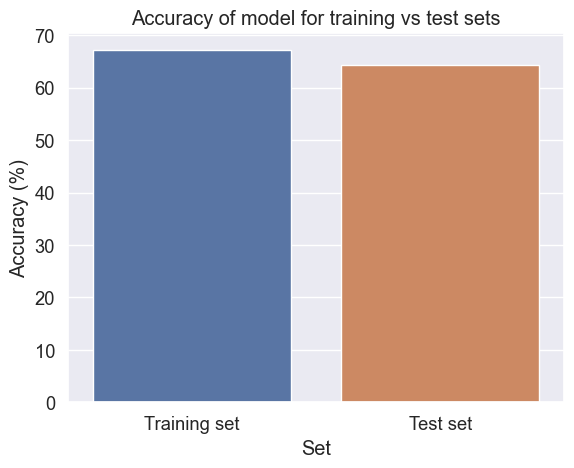

In [75]:
# TEST ACCURACY

# Training set
print("Training set")
print("Accuracy: ", accuracy_score(y_train, y_train_pred) * 100) #accuracy score
print("Number of mislabeled points: ", (y_train != y_train_pred).sum()) #mislabeled points

# Test set
y_test_pred = model.predict(X_test)
print("Test set")
print("Accuracy: ", accuracy_score(y_test, y_test_pred)*100) #accuracy score
print("Number of mislabeled points: ", (y_test != y_test_pred).sum()) #mislabeled points

# Plot
model_accuracies = pd.DataFrame({'Set':['Training set','Test set'], 'Accuracy (%)': [accuracy_score(y_train, y_train_pred) * 100, accuracy_score(y_test, y_test_pred)*100]})
sns.barplot(data=model_accuracies, x="Set", y="Accuracy (%)").set(title = 'Accuracy of model for training vs test sets' )
plt.savefig("../501-project-website/images/svm_"+str(mykernel)+"_tweets_accuracy.png")

/Users/cynthiang/opt/anaconda3/envs/class/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


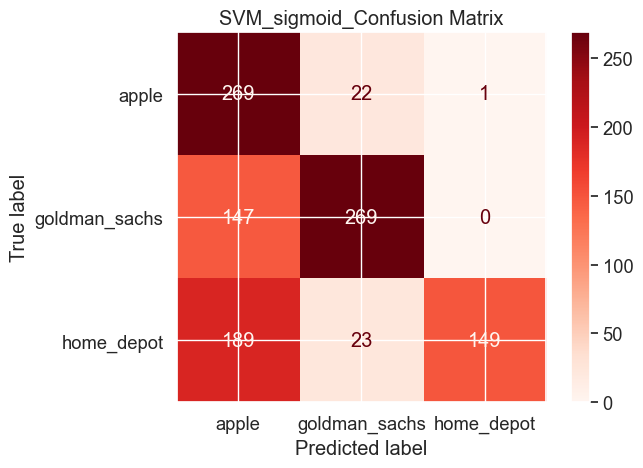

In [76]:
# CONFUSION MATRIX

# Import confusion matrix library
from sklearn.metrics import plot_confusion_matrix

# Create confusion matrix
plot_confusion_matrix(model, X_test , y_test , cmap="Reds")

# Plot confusion matrix
plt.title("SVM_"+str(mykernel)+"_Confusion Matrix")
plt.savefig("../501-project-website/images/SVM_"+str(mykernel)+"_record_confusion_matrix.png")

## SVM - Linear Kernel Model and Results

In [77]:
from sklearn.svm import SVC

# Initialize model

C=500
mykernel = 'linear'

model = SVC(C=C,kernel=mykernel)

model

# Fit to training data
model.fit(X_train, y_train) 

# Predict on X_train
y_train_pred = model.predict(X_train) 

Training set
Accuracy:  67.15823970037454
Number of mislabeled points:  1403
Test set
Accuracy:  64.26566884939196
Number of mislabeled points:  382


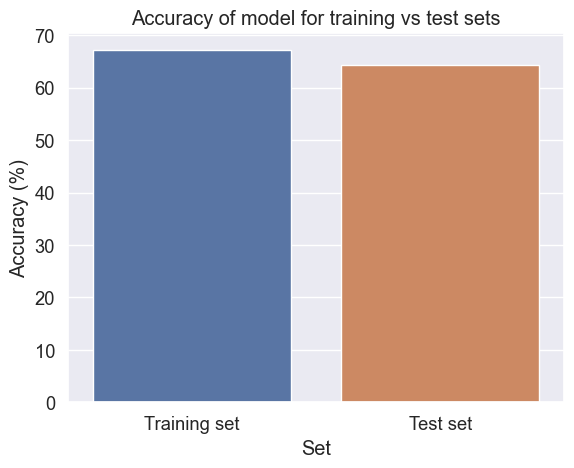

In [78]:
# TEST ACCURACY

# Training set
print("Training set")
print("Accuracy: ", accuracy_score(y_train, y_train_pred) * 100) #accuracy score
print("Number of mislabeled points: ", (y_train != y_train_pred).sum()) #mislabeled points

# Test set
y_test_pred = model.predict(X_test)
print("Test set")
print("Accuracy: ", accuracy_score(y_test, y_test_pred)*100) #accuracy score
print("Number of mislabeled points: ", (y_test != y_test_pred).sum()) #mislabeled points

# Plot
model_accuracies = pd.DataFrame({'Set':['Training set','Test set'], 'Accuracy (%)': [accuracy_score(y_train, y_train_pred) * 100, accuracy_score(y_test, y_test_pred)*100]})
sns.barplot(data=model_accuracies, x="Set", y="Accuracy (%)").set(title = 'Accuracy of model for training vs test sets' )
plt.savefig("../501-project-website/images/svm_"+str(mykernel)+"_tweets_accuracy.png")

/Users/cynthiang/opt/anaconda3/envs/class/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


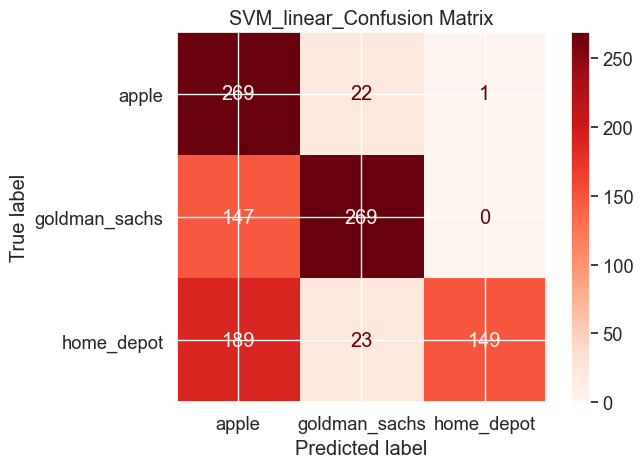

In [79]:
# CONFUSION MATRIX

# Import confusion matrix library
from sklearn.metrics import plot_confusion_matrix

# Create confusion matrix
plot_confusion_matrix(model, X_test , y_test , cmap="Reds")

# Plot confusion matrix
plt.title("SVM_"+str(mykernel)+"_Confusion Matrix")
plt.savefig("../501-project-website/images/SVM_"+str(mykernel)+"_record_confusion_matrix.png")

## SVM - RBF Kernel Model and Results

In [80]:
from sklearn.svm import SVC

# Initialize model

C=500
mykernel = 'rbf'

model = SVC(C=C,kernel=mykernel)

model

# Fit to training data
model.fit(X_train, y_train) 

# Predict on X_train
y_train_pred = model.predict(X_train) 

Training set
Accuracy:  67.15823970037454
Number of mislabeled points:  1403
Test set
Accuracy:  64.92048643592142
Number of mislabeled points:  375


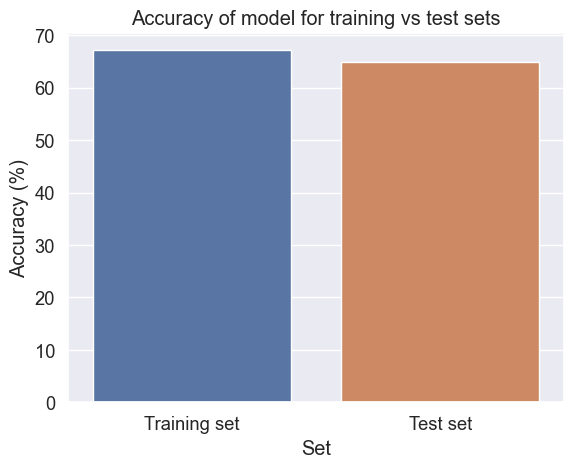

In [81]:
# TEST ACCURACY

# Training set
print("Training set")
print("Accuracy: ", accuracy_score(y_train, y_train_pred) * 100) #accuracy score
print("Number of mislabeled points: ", (y_train != y_train_pred).sum()) #mislabeled points

# Test set
y_test_pred = model.predict(X_test)
print("Test set")
print("Accuracy: ", accuracy_score(y_test, y_test_pred)*100) #accuracy score
print("Number of mislabeled points: ", (y_test != y_test_pred).sum()) #mislabeled points

# Plot
model_accuracies = pd.DataFrame({'Set':['Training set','Test set'], 'Accuracy (%)': [accuracy_score(y_train, y_train_pred) * 100, accuracy_score(y_test, y_test_pred)*100]})
sns.barplot(data=model_accuracies, x="Set", y="Accuracy (%)").set(title = 'Accuracy of model for training vs test sets' )
plt.savefig("../501-project-website/images/svm_"+str(mykernel)+"_tweets_accuracy.png")

/Users/cynthiang/opt/anaconda3/envs/class/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


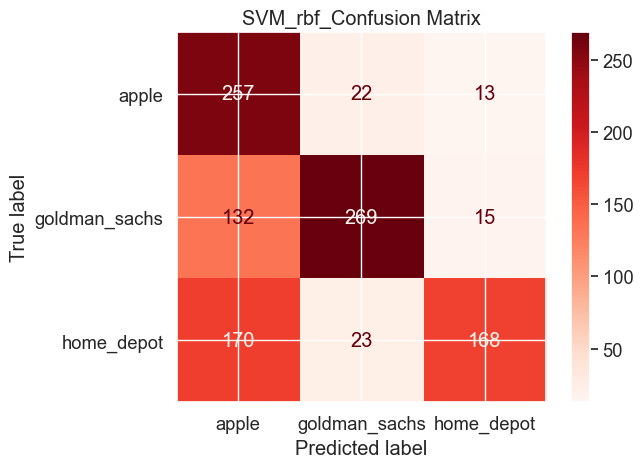

In [82]:
# CONFUSION MATRIX

# Import confusion matrix library
from sklearn.metrics import plot_confusion_matrix

# Create confusion matrix
plot_confusion_matrix(model, X_test , y_test , cmap="Reds")

# Plot confusion matrix
plt.title("SVM_"+str(mykernel)+"_Confusion Matrix")
plt.savefig("../501-project-website/images/SVM_"+str(mykernel)+"_record_confusion_matrix.png")

## SVM - Polynomial Kernel Model and Results

In [83]:
from sklearn.svm import SVC

# Initialize model

C=500
mykernel = 'poly'

model = SVC(C=C,kernel=mykernel)

model

# Fit to training data
model.fit(X_train, y_train) 

# Predict on X_train
y_train_pred = model.predict(X_train) 

Training set
Accuracy:  67.15823970037454
Number of mislabeled points:  1403
Test set
Accuracy:  64.26566884939196
Number of mislabeled points:  382


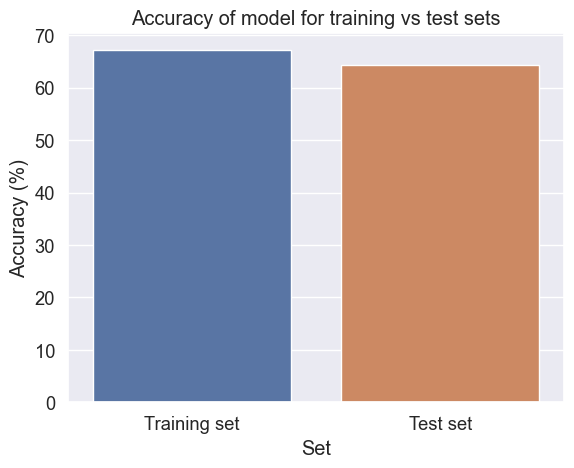

In [84]:
# TEST ACCURACY

# Training set
print("Training set")
print("Accuracy: ", accuracy_score(y_train, y_train_pred) * 100) #accuracy score
print("Number of mislabeled points: ", (y_train != y_train_pred).sum()) #mislabeled points

# Test set
y_test_pred = model.predict(X_test)
print("Test set")
print("Accuracy: ", accuracy_score(y_test, y_test_pred)*100) #accuracy score
print("Number of mislabeled points: ", (y_test != y_test_pred).sum()) #mislabeled points

# Plot
model_accuracies = pd.DataFrame({'Set':['Training set','Test set'], 'Accuracy (%)': [accuracy_score(y_train, y_train_pred) * 100, accuracy_score(y_test, y_test_pred)*100]})
sns.barplot(data=model_accuracies, x="Set", y="Accuracy (%)").set(title = 'Accuracy of model for training vs test sets' )
plt.savefig("../501-project-website/images/svm_"+str(mykernel)+"_tweets_accuracy.png")

/Users/cynthiang/opt/anaconda3/envs/class/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


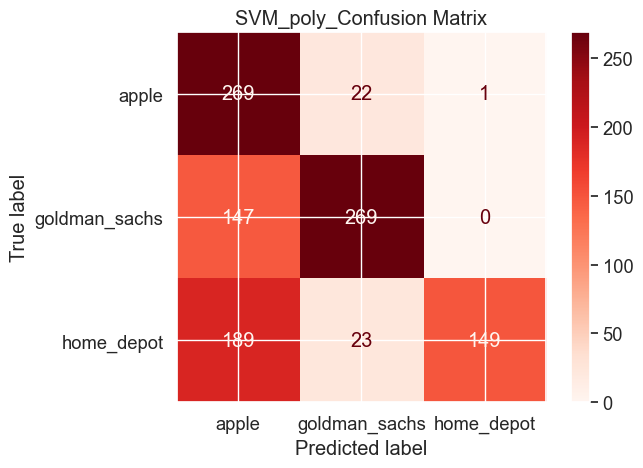

In [85]:
# CONFUSION MATRIX

# Import confusion matrix library
from sklearn.metrics import plot_confusion_matrix

# Create confusion matrix
plot_confusion_matrix(model, X_test , y_test , cmap="Reds")

# Plot confusion matrix
plt.title("SVM_"+str(mykernel)+"_Confusion Matrix")
plt.savefig("../501-project-website/images/SVM_"+str(mykernel)+"_record_confusion_matrix.png")